# Python library : torch_crosscor
The torch_crosscorr library provides a fast implementation of ZNCC for calculating the normalized cross-correlation between one real image and one another on PyTorch.
<br />
<br />
<br />
We provide 3 differents ways to compute the ZNCC, depending on your needs :
- Using spatial PyTorch convolution (Spatial)
- Using the hadamard product in the frequency domain (FFT)
- Using a naive approach that makes the scalar product on the unfolded image

The normalization can be made using the Lewis technique which consists to compute the denominator using integral images which reduces a lot the complexity of the algorithm. 

Computation time : 
- ~3.23 ms (FFT)
- ~1.43 s (Spatial) (x442 faster)
- ~2.37 s (Naive) (x734 faster)

Check speed comparison at the end of this readme.


# References :

- Lewis, J.P.. (1994). Fast Template Matching. Vis. Interface. 95. - https://www.researchgate.net/publication/242325076_Fast_Template_Matching



<hr />

# Install library


In [1]:
%%bash
if !python -c "import torch_crosscor" 2>/dev/null; then
    pip install https://github.com/Simon-Bertrand/FastCrossCorr-PyTorch/archive/main.zip
fi

Couldn't find program: 'bash'


# Import library


In [2]:
import torch_crosscorr

In [3]:
!pip install -q matplotlib torchvision
import torch
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
def imshow(im):
    if len(im.shape) == 4:
        im = im[0]
    fig, axes = plt.subplots(1, im.size(0), figsize=(12, 4))
    for ax, imC in zip(axes, im):
        im_ = ax.imshow(imC, cmap="gray")
        ax.yaxis.set_visible(False)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im_, cax=cbar_ax)
    plt.show()


i, j = 65, 40
sizeX, sizeY = 58, 58
im = torch.randn(1, 3, 256, 256, dtype=torch.float64)
imT = im[:, :, i - sizeX // 2 : i + sizeX // 2 + 1, j - sizeY // 2 : j + sizeY // 2 + 1]

## CHECK EQUALITY BETWEEN METHODS


In [5]:
for normalize in ["ncorr", "corr"]:
    for modeTest in [("fft", "spatial"), ("naive", "spatial"), ("fft", "naive")]:
        print(f"Method : {normalize} {modeTest}")
        print(
            "Max L1 distance : ",
            (
                torch_crosscorr.FastNormalizedCrossCorrelation(normalize, modeTest[0])(
                    im, imT
                )
                - torch_crosscorr.FastNormalizedCrossCorrelation(
                    normalize, modeTest[1]
                )(im, imT)
            )
            .abs()
            .max()
            .item(),
        )
        print("{:=^45}".format(""))

Method : ncorr ('fft', 'spatial')
Max L1 distance :  1.9984014443252818e-15
Method : ncorr ('naive', 'spatial')
Max L1 distance :  1.5543122344752192e-15
Method : ncorr ('fft', 'naive')
Max L1 distance :  6.661338147750939e-16
Method : corr ('fft', 'spatial')
Max L1 distance :  6.821210263296962e-12
Method : corr ('naive', 'spatial')
Max L1 distance :  5.4569682106375694e-12
Method : corr ('fft', 'naive')
Max L1 distance :  2.2737367544323206e-12


## LOAD IMAGE AND TEST IF RANDOM EXTRACTED CENTER POSITIONS ARE CORRECTLY FOUND

Install notebook dependencies

In [6]:
!pip install -q requests
import requests


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Load Mandrill image

In [7]:
import tempfile
import torchvision
import torch.nn.functional as F


im = F.interpolate(
    (
        torchvision.io.read_image("figs/sample.png", torchvision.io.ImageReadMode.RGB)
        .unsqueeze(0)
        .to(torch.float64)
        .div(255)
    ),
    size=(256, 256),
    mode="bicubic",
    align_corners=False,
)

Run multiple tests to check if random crop center is correclty found by the ZNCC.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016961550245098038..1.0345664828431371].


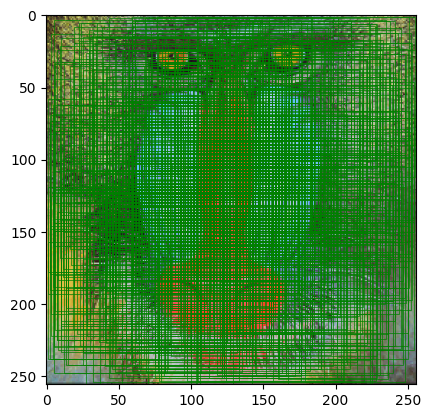

In [8]:
import random

success = 0
failed = 0
pts = []
for _ in range(500):
    imH = random.randint(64, 128)
    imW = random.randint(64, 128)
    i = random.randint(imH // 2 + 1, im.size(-2) - imH // 2 - 1)
    j = random.randint(imW // 2 + 1, im.size(-1) - imW // 2 - 1)

    imT = im[:, :, i - imH // 2 : i + imH // 2 + 1, j - imW // 2 : j + imW // 2 + 1]
    out =  torch_crosscorr.FastNormalizedCrossCorrelation("ncorr", "fft")(im, imT)
    out_amax = out.sum(-3).flatten(-2).argmax(-1)
    if (
        (
            torch.Tensor([[[out_amax//out.size(-1)]], [[out_amax%out.size(-1)]]])
            - torch.Tensor([[[i]], [[j]]])
        ).abs()
        < 3
    ).all():
        pts += [
            dict(
                i=i,
                imH=imH,
                imW=imW,
                j=j,
                success=True,
            )
        ]
        success += 1
    else:
        pts += [
            dict(
                i=i,
                imH=imH,
                imW=imW,
                j=j,
                success=False,
            )
        ]
        failed += 1

plt.imshow(im[0].moveaxis(0, -1))
ax = plt.gca()
for pt in pts:
    ax.add_patch(
        plt.Rectangle(
            (pt["j"] - pt["imW"] // 2, pt["i"] - pt["imH"] // 2),
            pt["imW"],
            pt["imH"],
            edgecolor="g" if pt["success"] else "r",
            facecolor="none",
            linewidth=0.5,
        )
    )

Total errors : 

In [9]:
dict(success=success, failed=failed)

{'success': 500, 'failed': 0}

# SPEEDTEST

In [10]:
%timeit torch_crosscorr.FastNormalizedCrossCorrelation("ncorr","fft")(im, imT)
%timeit torch_crosscorr.FastNormalizedCrossCorrelation("ncorr","spatial")(im, imT)
%timeit torch_crosscorr.FastNormalizedCrossCorrelation("ncorr", "naive")(im, imT)

5.23 ms ± 86.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
971 ms ± 4.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.88 s ± 84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
